In [5]:
import pandas as pd

download_path = '../vocal_patterns/data'
metadata_file = f"{download_path}/dataset_tags.csv"

df = pd.read_csv(metadata_file)
df.head()


,path,exercise,technique,filename
0,/Users/jake/code/jchaselubitz/vocal_patterns/v...,Other,vibrato,m6_row_vibrato.wav
1,/Users/jake/code/jchaselubitz/vocal_patterns/v...,Other,vibrato,m6_caro_vibrato.wav
2,/Users/jake/code/jchaselubitz/vocal_patterns/v...,Other,vibrato,m6_dona_vibrato.wav
3,/Users/jake/code/jchaselubitz/vocal_patterns/v...,Other,straight,m6_caro_straight.wav
4,/Users/jake/code/jchaselubitz/vocal_patterns/v...,Other,straight,m6_row_straight.wav


In [87]:
import librosa
from librosa.feature import melspectrogram
import numpy as np
from IPython.display import Audio

class AudioUtilLibrosa():
  # ----------------------------
  # Load an audio file. Return the signal as a numpy array and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    # By default, librosa converts the audio to mono (num_channels = 1)
    sig, sr = librosa.load(audio_file, sr=22050, mono=False)
    return (sig, sr)

  # ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if sig.ndim == 1:
      # If the audio is mono, it will have only one dimension
      num_channels = 1
    else:
      # If the audio is stereo or more, the number of channels is the size of the first dimension
      num_channels = sig.shape[0]

    if (num_channels == new_channel):
      # If the number of channels is already as desired, return the original
      return aud

    if (new_channel == 1):
      # If converting to mono, average the channels
      resig = np.mean(sig, axis=0, keepdims=True)
    else:
      # If converting to stereo, just duplicate the first channel (if originally mono)
      resig = np.vstack([sig, sig]) if num_channels == 1 else sig

    return (resig, sr)
  
  
  @staticmethod
  def pad_trunc(aud, max_ms):
      sig, sr = aud
      if sig.ndim == 1:
          # If the signal is mono
          num_rows = 1
          sig_len = sig.shape[0]
      else:
          # If the signal is stereo or more
          num_rows, sig_len = sig.shape

      max_len = sr // 1000 * max_ms

      if (sig_len > max_len):
          # Truncate the signal to the given length
          sig = sig[:, :max_len] if num_rows > 1 else sig[:max_len]

      elif (sig_len < max_len):
          # Length of padding to add at the beginning and end of the signal
          pad_begin_len = np.random.randint(0, max_len - sig_len)
          pad_end_len = max_len - sig_len - pad_begin_len

          # Pad with 0s
          pad_begin = np.zeros((num_rows, pad_begin_len))
          pad_end = np.zeros((num_rows, pad_end_len))

          sig = np.concatenate((pad_begin, sig, pad_end), axis=1 if num_rows > 1 else 0)

      return (sig, sr)
    
    
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
      sig, sr = aud
      # If stereo, convert to mono by averaging the channels
      if sig.ndim > 1:
          sig = np.mean(sig, axis=0)
      spec = melspectrogram(y=sig, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_len)
      # Convert to decibels
      spec_db = librosa.amplitude_to_db(spec, ref=np.max)
      return spec_db


# Example usage
audio_path = df.iloc[5]['path']
audio_file = Audio(audio_path)
audio_data = AudioUtilLibrosa.open(audio_path)
stereo_audio = AudioUtilLibrosa.rechannel(audio_data, 1)
truncate_audio = AudioUtilLibrosa.pad_trunc(stereo_audio, 3000)
spectrogram = AudioUtilLibrosa.spectro_gram(truncate_audio)

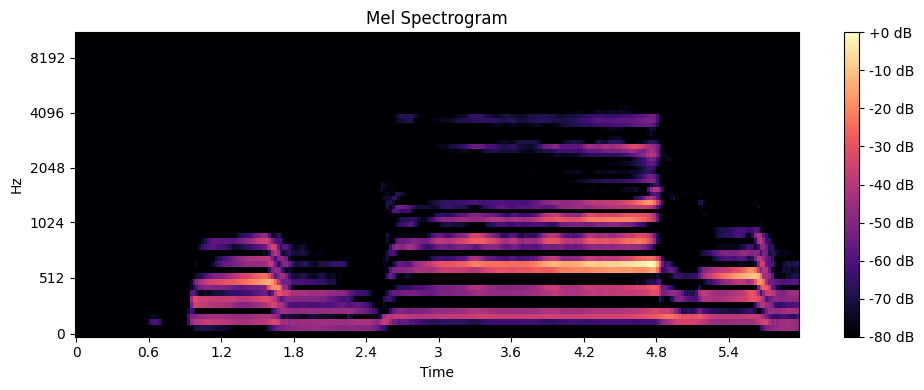

In [88]:
import librosa.display
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram, sr=audio_data[1], x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()